# Dependency File

In [1]:
# !wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

# Dependency Packages

In [2]:
# !pip3 -q install contractions
# !pip3 -q install nb_black
# !pip -q install beautifulsoup4

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [39]:
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/user/Applications/machine-learning/nlp/natural-disaster-tweets'))
if module_path not in sys.path:
    sys.path.append(module_path)

# **Imports**

In [69]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import os
import matplotlib.pyplot as plt
from matplotlib import pylab
import emoji
import re
import contractions
from bs4 import BeautifulSoup
import unicodedata
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import tensorflow_hub as hub
import lib.tokenization as tokenization
from tensorflow import keras
from kerastuner.tuners import Hyperband
from sklearn.model_selection import train_test_split
import time

<IPython.core.display.Javascript object>

# Vocablury for NLTK

In [41]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Jupyter Configurations for autocomplete, formatter

In [42]:
%config IPCompleter.greedy=True
%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Path to Train and Test Files

In [43]:
# Constants
curr_dir = "../.."
already_trained = True  # set this to false to retrain.
train_file = os.path.join(curr_dir, "dataset", "train.csv")
test_file = os.path.join(curr_dir, "dataset", "test.csv")
sample_submission_file = os.path.join(curr_dir, "dataset", "sample_submission.csv")

<IPython.core.display.Javascript object>

In [44]:
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (16, 5),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

<IPython.core.display.Javascript object>

In [45]:
df = pd.read_csv(train_file)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<IPython.core.display.Javascript object>

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<IPython.core.display.Javascript object>

In [47]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

<IPython.core.display.Javascript object>

# Data Analysis Start

In [48]:
def plotBarGraph(data, labelx, labely, title, switch_axis=False):
    y = data.index.tolist()
    x = data.tolist()
    if switch_axis:
        x = data.index.tolist()
        y = data.tolist()
    sns.barplot(y=y, x=x)
    plt.title(title)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.show()

<IPython.core.display.Javascript object>

# Tweet Locations Graph

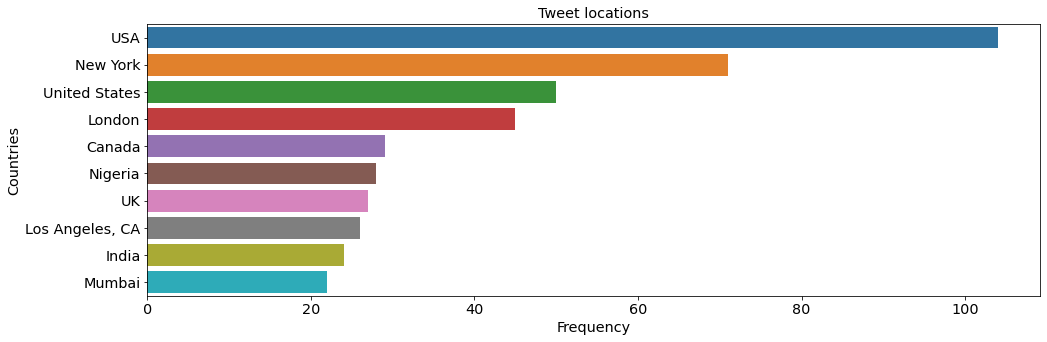

<IPython.core.display.Javascript object>

In [49]:
locations_map = df.location.value_counts().sort_values(ascending=False)[:10]
plotBarGraph(locations_map, "Frequency", "Countries", "Tweet locations")

# Top 20 Disaster-Related Keywords

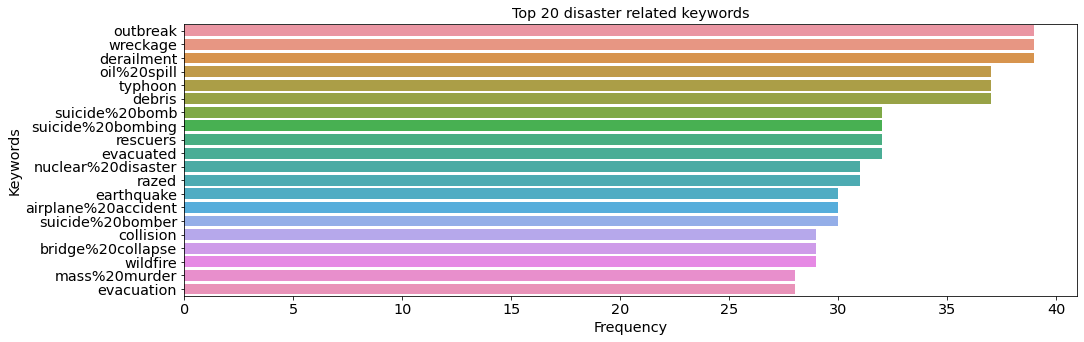

<IPython.core.display.Javascript object>

In [50]:
# Top 20 Disaster related Keywords
keywords_map = (
    df.keyword.loc[df.target == 1].value_counts().sort_values(ascending=False)[:20]
)
plotBarGraph(keywords_map, "Frequency", "Keywords", "Top 20 disaster related keywords")

# Top 20 Non-Disaster-Related Keywords
* Notice non-disaster keywords are not actual disasters but rather general keywords that could describe a disaster. These keywords can be used in our daily lives, for instance "I started panicing when I got into MIT", which clearly isn't a natural disaster lol :)

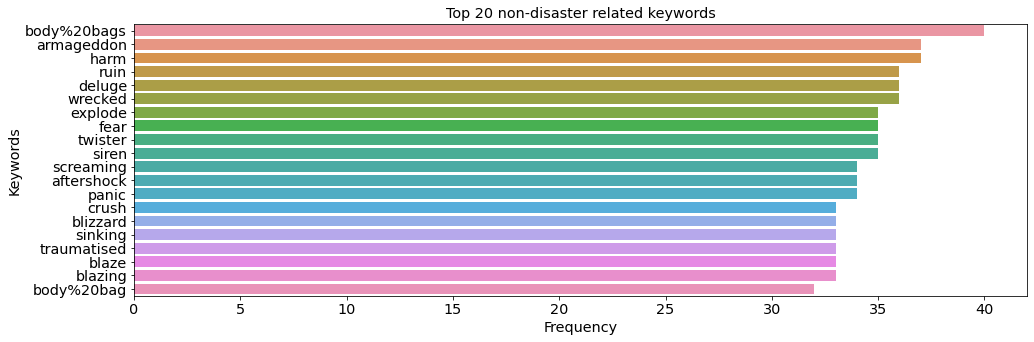

<IPython.core.display.Javascript object>

In [51]:
# Top 20 Non-Disaster related Keywords
keywords_non_disaster_map = df.keyword.loc[df.target == 0].value_counts(
    ascending=False
)[:20]
plotBarGraph(
    keywords_non_disaster_map,
    "Frequency",
    "Keywords",
    "Top 20 non-disaster related keywords",
)

# Target Distrubution

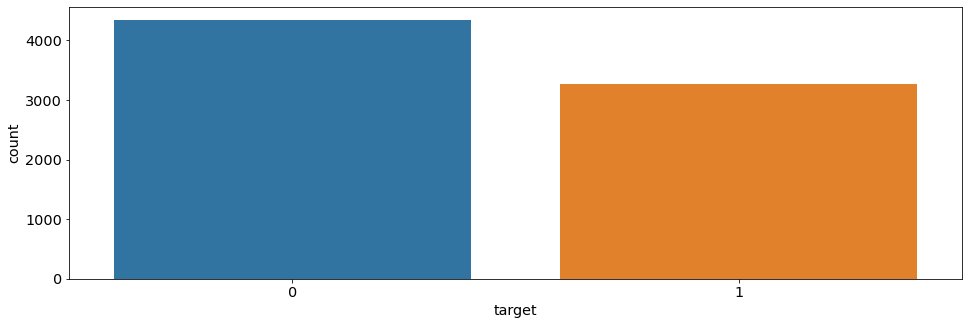

<IPython.core.display.Javascript object>

In [52]:
sns.countplot(x="target", data=df)
plt.show()

# Duplicates in Input Text Data

False    7503
True      110
Name: text, dtype: int64


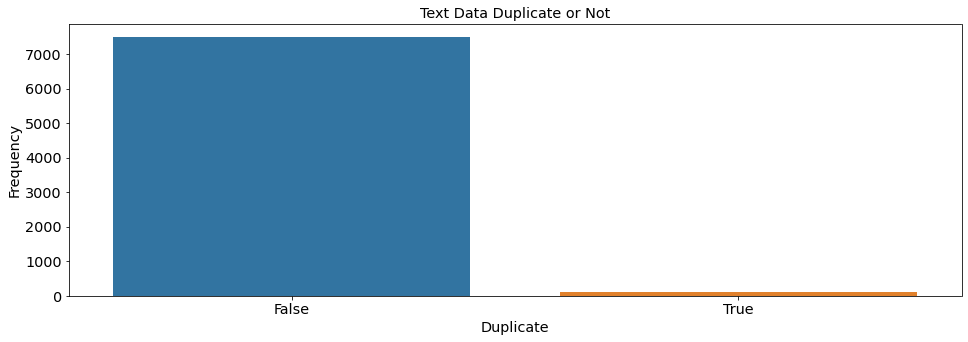

<IPython.core.display.Javascript object>

In [16]:
# Removing Duplicate Text Data
text_data_duplicate_map = df.text.duplicated().value_counts()
print(text_data_duplicate_map)
plotBarGraph(
    text_data_duplicate_map,
    "Duplicate",
    "Frequency",
    "Text Data Duplicate or Not",
    switch_axis=True,
)

# Remove Duplicates and only Keeping Original Text

In [53]:
print("Original dataframe shape: ", df.shape)
df.drop_duplicates(subset="text", keep="first", inplace=True)
print("Dropping duplicate rows and keeping original value shape: ", df.shape)
df.text.duplicated().value_counts()

Original dataframe shape:  (7613, 5)
Dropping duplicate rows and keeping original value shape:  (7503, 5)


False    7503
Name: text, dtype: int64

<IPython.core.display.Javascript object>

# Search Keywords in Text Column for Debugging Purposes

In [54]:
def search_text_data(query, column="text"):
    return df[df[column].str.contains(query)][column]


print(search_text_data("volcano")[:5])

1368    @POTUS Would you please explain what you are g...
3041    #SCSeEstaPreparando Light mag. 4.4 earthquake ...
4714    The sunset looked like an erupting volcano ......
6771    Maybe that's what happens when a tornado meets...
7126    Jetstar and Virgin forced to cancel Bali fligh...
Name: text, dtype: object


<IPython.core.display.Javascript object>

# Lowercase Data

In [55]:
# Lower case text data
def lower_case_data(data=""):
    data = data.lower()
    return data

<IPython.core.display.Javascript object>

# Handle Emojis

In [56]:
# Handle Emojis
def sentences_with_emojis(id_texts):
    sentences = []
    indeces = id_texts[0]
    texts = id_texts[1]
    for index, sentence in zip(indeces, texts):
        has_emoji = bool(emoji.get_emoji_regexp().search(sentence))
        if has_emoji:
            sentences.append((index, sentence))
    if len(sentences) == 0:
        return "Sentences are clean and don't have emojis!"
    else:
        return sentences


# Source: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def clean_emojis(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = " ".join(
        [str for str in text.split() if not any(i in str for i in emoji_list)]
    )
    return clean_text

<IPython.core.display.Javascript object>

# Clean Urls

In [57]:
# Clean urls
def clean_urls(text):
    text = re.sub(r"https?://\S+", "", text)
    return text

<IPython.core.display.Javascript object>

# Remove Special Characters

In [58]:
# Remove all sorts of special characters and punctuations.
def removeSpecialChar(text):
    sentence = []
    for s in text:
        if s == " ":
            sentence.append(s)
        if s.isalnum():
            sentence.append(s)
    return "".join(sentence)

<IPython.core.display.Javascript object>

# Check HTML

In [59]:
# Check any html text in df.text (not cleaned yet) column
def checkHtml(text):
    return bool(BeautifulSoup(text, "html.parser").find())


html_sentence_map = df["text"].apply(checkHtml).tolist()
if not any(html_sentence_map):
    print("No text containing html found!")
else:
    print("There is some html text!")

No text containing html found!


<IPython.core.display.Javascript object>

# Remove Accented Characters

In [60]:
# Remove accented text
def remove_accented_chars(text):
    new_text = (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )
    return new_text

<IPython.core.display.Javascript object>

# Preprocesses Nltk Stopwords

In [61]:
# Explore Stopwords list from nltk
def remove_words_having_not(words=[""]):
    for word in words:
        if "not" in word:
            words.remove(word)
    return words


stopwords_list = stopwords.words("english")
print(stopwords_list)
stopwords_list = remove_words_having_not(
    [removeSpecialChar(contractions.fix(word)) for word in stopwords_list]
)
print("\n---------------Stopwords after preprocessing---------------\n")
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

<IPython.core.display.Javascript object>

# Remove stopwords

In [62]:
# Remove stopwords from nltk corpus
def remove_stopwords(text):
    new_sentence = ""
    for word in text.split():
        if word not in stopwords_list:
            new_sentence += word + " "
    return new_sentence

<IPython.core.display.Javascript object>

# Remove numbers from Text

In [63]:
# Remove numbers from text
def remove_numbers(text=""):
    new_sentence = ""
    for word in text.split():
        num_free_word = "".join([i for i in word if not i.isdigit()])
        new_sentence += num_free_word + " "
    return new_sentence

<IPython.core.display.Javascript object>

# Lemmatize Text
* Essentially simplify each word in the sentence to it's basic form. eg. residents->resident

In [64]:
# lemmatization
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    new_sentence = ""
    for word in text.split():
        lematized_word = lemmatizer.lemmatize(word)
        new_sentence += lematized_word + " "
    return new_sentence

<IPython.core.display.Javascript object>

# Remove WhiteSpaces

In [65]:
# Final data cleaning step is removing non-essential whitespaces
def remove_white_space(text):
    return " ".join(text.split())

<IPython.core.display.Javascript object>

# Clean any text column pipeline

In [66]:
# Text cleaning pipeline
def clean_sentence_pipeline(text):
    text = lower_case_data(text)
    text = clean_emojis(text)
    text = clean_urls(text)
    text = contractions.fix(text)
    text = removeSpecialChar(text)
    text = remove_accented_chars(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    text = lemmatize(text)
    return remove_white_space(text)


def clean_text_column(col_name, df=df):
    df["clean_text"] = ""
    df["clean_text"] = df[col_name].apply(clean_sentence_pipeline)


clean_text_column("text")

<IPython.core.display.Javascript object>

# Comparisons of Cleaned Text

In [67]:
# Comparison of cleaned texts
df[["text", "clean_text"]]

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...
...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,worldnews fallen powerlines glink tram update ...
7605,on the flip side I'm at Walmart and there is a...,flip side I walmart bomb everyone evacuate sta...
7606,Suicide bomber kills 15 in Saudi security site...,suicide bomber kill saudi security site mosque...
7608,Two giant cranes holding a bridge collapse int...,two giant crane holding bridge collapse nearby...


<IPython.core.display.Javascript object>

# BERT: Bidirectional Encoder Representations from Transformers

## Vocab:
1. Masked Language Model: Mask random words in a sentence(fill in the blanks) 
    to understand bidirectional context.
2. Next sentence prediction: Two sentences and detect which sentences follows each other.

## Process:
**Token inputs -> BERT Transformer Encoders -> Output as next sentence prediction and mask language modeling
-> Pass to feedforward for classification.**

## Token Inputs:
To generate token inputs, we need token embeddings(WordPiece Embedding) + Segment Embeddings(distinguish sentences) + Position Embeddings(position of word within a sentence encoded as a vector).

1. token embeddings: [CLS] token in the beginning of the sentence and [SEP] token at the end of the sentence
2. segment embeddings: distinguish sentences with tokens assigned to each sentence
3. position embedding: unique tokens assigned to each word in the sentence.

# BERT Layer and Tokenizer from BERT team

In [70]:
# Bert config
bert_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True
)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

<IPython.core.display.Javascript object>

## Experiment with Tokenizer and it's functionalities

In [71]:
# test tokenizer
normal_sentence = "covid-19 sucks like hell!"
tokenize_sentence = tokenizer.tokenize(normal_sentence)
print("Tokens for BERT: ", tokenize_sentence)
bert_input_sentence = ["[CLS]"] + tokenize_sentence + ["[SEP]"]
print("Token Ids for BERT: ", tokenizer.convert_tokens_to_ids(bert_input_sentence))

Tokens for BERT:  ['co', '##vid', '-', '19', 'sucks', 'like', 'hell', '!']
Token Ids for BERT:  [101, 2522, 17258, 1011, 2539, 19237, 2066, 3109, 999, 102]


<IPython.core.display.Javascript object>

# BERT Encoder

In [72]:
def bert_encode(texts, max_length=128):
    all_token_ids = []
    all_input_ids = []
    all_segment_ids = []
    for sentence in texts:
        tokenize_sentence = tokenizer.tokenize(sentence)[
            :max_length
        ]  # limit sentence to only 128 tokens
        bert_input_sentence = ["[CLS]"] + tokenize_sentence + ["[SEP]"]

        unused_sentence_length = max_length - len(
            bert_input_sentence
        )  # Max sentence length is 128, input sentence length is x so unused length is 128-x
        unused_length_array = [0] * unused_sentence_length

        token_ids = (
            tokenizer.convert_tokens_to_ids(bert_input_sentence) + unused_length_array
        )
        bert_input_ids = ([1] * len(bert_input_sentence)) + unused_length_array
        bert_segment_ids = [0] * max_length

        all_token_ids.append(token_ids)
        all_input_ids.append(bert_input_ids)
        all_segment_ids.append(bert_segment_ids)
    return (
        np.array(all_token_ids),
        np.array(all_input_ids),
        np.array(all_segment_ids),
    )

<IPython.core.display.Javascript object>

# BERT Pretrained Layer with Custom Feed-Forward Neural Network

In [73]:
MAX_SEQUENCE_LENGTH = 128


def build_model(hp):
    input_word_ids = keras.Input(
        shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_word_ids"
    )
    input_mask = keras.Input(
        shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_mask"
    )
    segment_ids = keras.Input(
        shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="segment_ids"
    )

    pooled_output, sequence_output = bert_layer(
        [input_word_ids, input_mask, segment_ids]
    )
    clf_output = sequence_output[:, 0, :]
    neural_inputs = keras.layers.Dense(
        units=hp.Int(
            "units_hidden_1", min_value=32, max_value=256, step=32, default=128
        ),
        activation="elu",
        kernel_initializer="he_normal",
    )(clf_output)
    neural_inputs = keras.layers.Dropout(
        rate=hp.Float("dropout_1", min_value=0.1, max_value=0.9, default=0.2, step=0.1)
    )(neural_inputs)
    neural_inputs = keras.layers.Dense(
        units=hp.Int(
            "units_hidden_2", min_value=32, max_value=256, step=32, default=64
        ),
        activation="elu",
        kernel_initializer="he_normal",
    )(neural_inputs)
    neural_inputs = keras.layers.Dropout(
        rate=hp.Float("dropout_2", min_value=0.1, max_value=0.9, default=0.2, step=0.1)
    )(neural_inputs)
    out = keras.layers.Dense(
        1,
        activation="sigmoid",
    )(neural_inputs)
    model = keras.models.Model(
        inputs=[input_word_ids, input_mask, segment_ids], outputs=out
    )
    model.compile(
        keras.optimizers.Adam(hp.Choice("learning_rate", [5e-5, 3e-5, 1e-5])),
        loss=keras.losses.binary_crossentropy,
        metrics=["accuracy"],
    )

    return model

<IPython.core.display.Javascript object>

# Hyperband Hyperparameter Tuning Mechanism
I don't know why kaggle couldn't save the hyperparameter folder.

In [75]:
tuner = Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=3,
    project_name="../../hyperparameter/hyperband",
)

<IPython.core.display.Javascript object>

# Train-Test Split

In [76]:
# Prepare final datasplits
x_train, x_val, y_train, y_val = train_test_split(
    df.clean_text, df.target, train_size=0.85
)

<IPython.core.display.Javascript object>

# BERT Encoding Calls on Train and Validation

In [77]:
bert_xtrain = bert_encode(x_train)
bert_xval = bert_encode(x_val)

<IPython.core.display.Javascript object>

# Keras Callbacks

In [82]:
model_path = os.path.join(
    "../..", "models", "keras_hyperband_disaster_prediction.h5"
)  # for local development
tensorboard_logs_path = os.path.join("../..", "tensorboard_logs")
# Keras callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=model_path, save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)
# Tensorboard callback
tensorboard_cb = keras.callbacks.TensorBoard(
    os.path.join(tensorboard_logs_path, time.strftime("run_%Y_%m_%d_at_%H_%M_%S"))
)

<IPython.core.display.Javascript object>

# Type change for passing it in Tuner
* This was a bug where a numpy array couldn't be converted to a tenson before passing it into the model, for more reference check out [link](https://stackoverflow.com/a/60750937/10016132)

In [79]:
bert_xtrain = np.asarray(bert_xtrain).astype(np.float32)
bert_xval = np.asarray(bert_xval).astype(np.float32)

<IPython.core.display.Javascript object>

# Training! Best Validation Accuracy is 83.46%

In [41]:
if not already_trained:
    tuner.search(
        {
            "input_word_ids": bert_xtrain[0],
            "input_mask": bert_xtrain[1],
            "segment_ids": bert_xtrain[2],
        },
        y_train,
        epochs=3,
        batch_size=32,
        validation_data=(
            {
                "input_word_ids": bert_xval[0],
                "input_mask": bert_xval[1],
                "segment_ids": bert_xval[2],
            },
            y_val,
        ),
        callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
    )
else:
    None

Trial 6 Complete [00h 05m 04s]
val_accuracy: 0.8126109838485718

Best val_accuracy So Far: 0.838365912437439
Total elapsed time: 00h 19m 37s


<IPython.core.display.Javascript object>

# Load Saved Model

In [83]:
bert_model = keras.models.load_model(
    model_path,
    custom_objects={"KerasLayer": hub.KerasLayer},
)
bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

<IPython.core.display.Javascript object>

# My Custom BERT Model

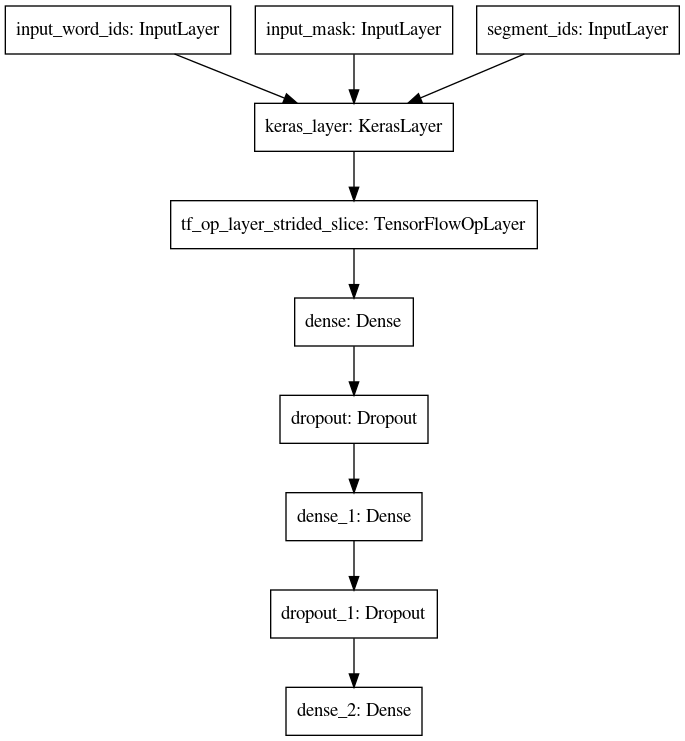

<IPython.core.display.Javascript object>

In [43]:
tf.keras.utils.plot_model(bert_model, to_file="bert_model.png", dpi=96)

# Test set preprocessing

In [84]:
# Read Test Set
df_test = pd.read_csv(test_file)
# Preprocess Test Set
clean_text_column("text", df_test)
bert_test = bert_encode(df_test.clean_text)
df_test.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


<IPython.core.display.Javascript object>

# Compute Predictions

In [45]:
pred = bert_model.predict(bert_test) # Requires GPU access

<IPython.core.display.Javascript object>

# Submission

In [46]:
round_predictions = pred.round().astype("int")
df_submit = pd.read_csv(sample_submission_file)
df_submit["target"] = round_predictions
df_submit.to_csv("submission.csv", index=False, header=True)

<IPython.core.display.Javascript object>